Resolving cifar10_dataset classification problem.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import time

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=x_train.shape[1:]
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense1_units', min_value=32, max_value=512, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(10, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cifar10_cnn'
)

early_stop = EarlyStopping(monitor='val_loss', patience=3)

start_time = time.time()
tuner.search(
    x_train,
    y_train,
    epochs=5,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)
end_time = time.time()

best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print('Best model:')
best_model.summary()
print('Test accuracy:', test_acc)

elapsed_time = end_time - start_time
print('Elapsed time:', elapsed_time, 'seconds')


In [3]:
#Implementation of best results and run for only 2 epochs(it should be in real running at least 50):


from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model = keras.Sequential([
    layers.Conv2D(64, 5, padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=[keras.metrics.CategoricalAccuracy(name='accuracy'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')
            ]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-7, 
    verbose=1,
    mode='min'
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

history = model.fit(
    x_train, 
    y_train, 
    epochs=2, 
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Test AUC:', test_auc)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)


Epoch 1/2
782/782 [==============================] - ETA: 0s - loss: 1.4967 - accuracy: 0.5106 - auc: 0.8826 - precision: 0.6049 - recall: 0.4122
Epoch 1: val_accuracy improved from -inf to 0.36690, saving model to best_model.h5
782/782 [==============================] - 369s 469ms/step - loss: 1.4967 - accuracy: 0.5106 - auc: 0.8826 - precision: 0.6049 - recall: 0.4122 - val_loss: 1.8294 - val_accuracy: 0.3669 - val_auc: 0.8387 - val_precision: 0.4336 - val_recall: 0.2724 - lr: 5.0000e-04
Epoch 2/2
782/782 [==============================] - ETA: 0s - loss: 0.9375 - accuracy: 0.6743 - auc: 0.9494 - precision: 0.7689 - recall: 0.5834
Epoch 2: val_accuracy improved from 0.36690 to 0.63010, saving model to best_model.h5
782/782 [==============================] - 381s 487ms/step - loss: 0.9375 - accuracy: 0.6743 - auc: 0.9494 - precision: 0.7689 - recall: 0.5834 - val_loss: 1.0750 - val_accuracy: 0.6301 - val_auc: 0.9337 - val_precision: 0.7479 - val_recall: 0.5237 - lr: 5.0000e-04
Test Lo

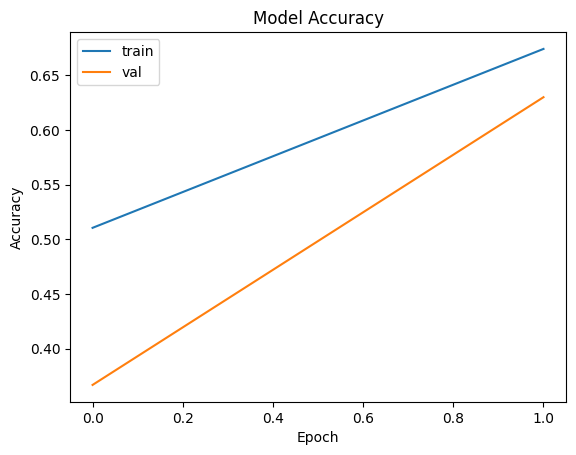

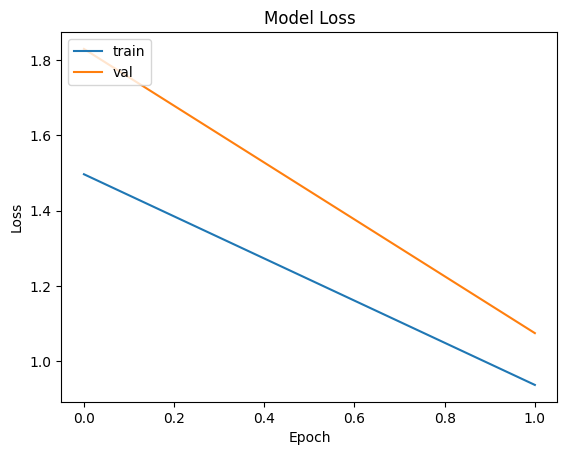

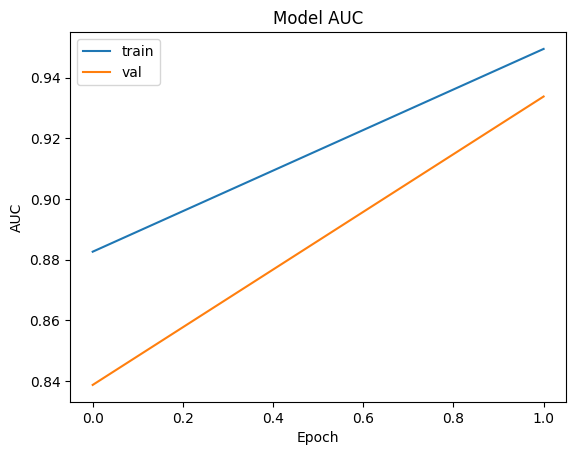

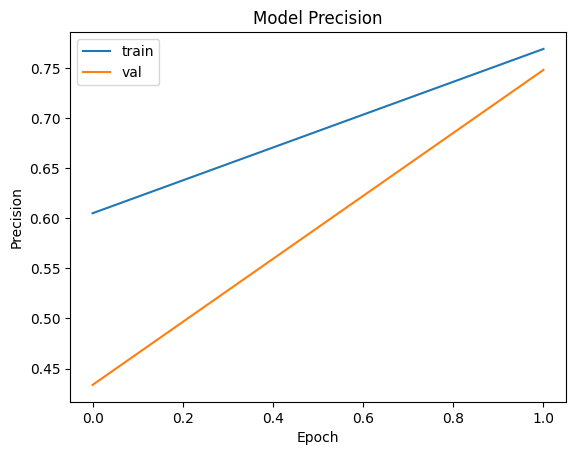

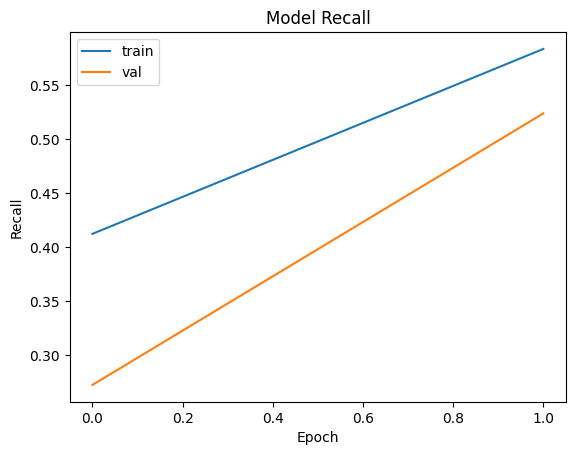

In [4]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
#Using LeNet5 to resolve this problem: 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

model = keras.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

for layer in model.layers:
    if isinstance(layer, layers.Conv2D) and layer.name == 'conv2d':
        layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_frozen = model.fit(x_train, y_train, epochs=25, validation_data=(x_test, y_test))

for layer in model.layers:
    if isinstance(layer, layers.Conv2D) and layer.name == 'conv2d':
        layer.trainable = True

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_unfrozen = model.fit(x_train, y_train, epochs=25, validation_data=(x_test, y_test))

import matplotlib.pyplot as plt

plt.plot(history_frozen.history['accuracy'] + history_unfrozen.history['accuracy'], label='Training Accuracy')
plt.plot(history_frozen.history['val_accuracy'] + history_unfrozen.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_frozen.history['loss'] + history_unfrozen.history['loss'], label='Training Loss')
plt.plot(history_frozen.history['val_loss'] + history_unfrozen.history['val_loss'], label='Validation Loss')
plt.title('LeNet-5 CIFAR-10 Classification')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()


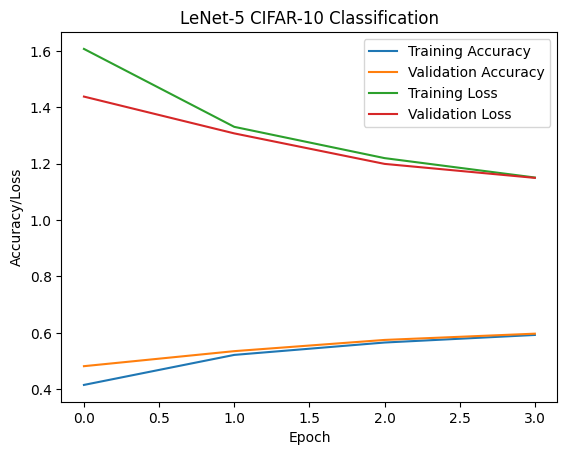